In [100]:
import pymc as pm
import polars as pl
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

from sklearn.preprocessing import OneHotEncoder

In [101]:
pl_nsw = pl.read_csv("./data/ec675_nsw.tab", separator="\t")

pl_nsw.group_by("treated").agg(pl.len().alias("cnt"))

treated,cnt
str,u32
"""1""",297
null,18482
"""0""",425


In [102]:
# Remove comparison units not part of experimental study
pl_nsw = pl_nsw.filter(pl.col("treated").is_null().not_()).with_columns(
    pl.col("treated").cast(pl.Int64)
)

pl_nsw.head()

treated,age,educ,black,married,nodegree,dwincl,re74,re75,re78,hisp,early_ra,sample
i64,i64,i64,i64,i64,i64,str,f64,f64,f64,i64,str,f64
1,33,12,0,1,0,"""1""",0.0,0.0,12418.07,0,"""0""",1.0
1,20,12,0,1,0,"""0""",8644.156,8644.156,11656.506,0,"""0""",1.0
0,39,12,1,1,0,"""1""",19785.32,6608.137,499.2572,0,"""1""",1.0
1,49,8,0,1,1,"""0""",9714.597,7285.9478,16717.121,0,"""0""",1.0
0,26,8,0,1,1,"""0""",37211.758,36941.266,30247.5,0,"""0""",1.0


In [103]:
# re75 is revenue pre-training, re78 is at outcome
variable_selection = ["age", "treated", "educ", "black", "hisp", "married", "nodegree", "re74", "re75", "re78"]
pl_nsw = pl_nsw.select(variable_selection)

<Axes: xlabel='re75', ylabel='Density'>

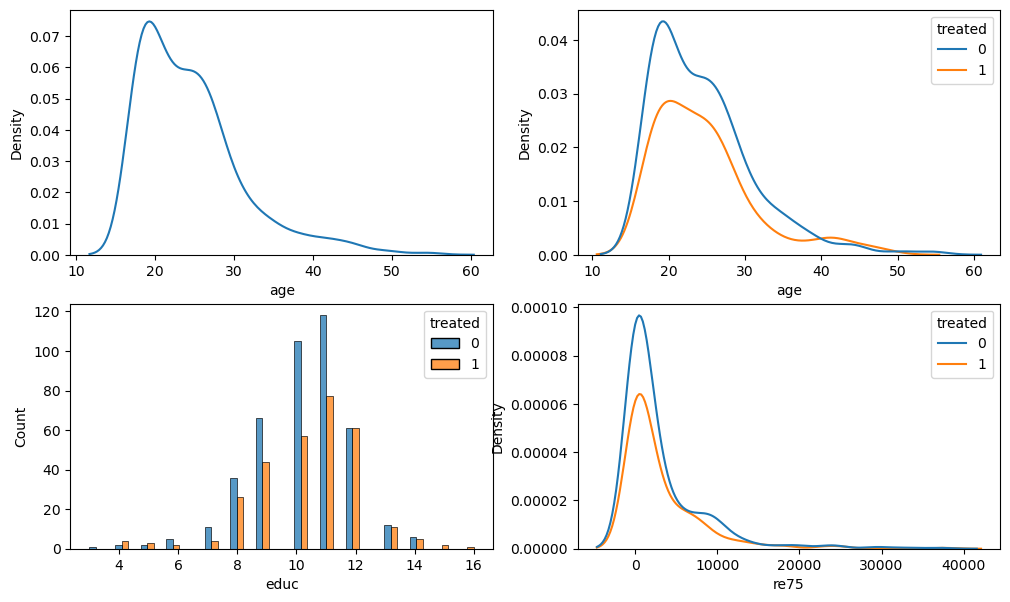

In [104]:
# Descriptives
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 7))
sns.kdeplot(pl_nsw, x="age", ax=ax[0, 0])
sns.kdeplot(pl_nsw, x="age", hue="treated", ax=ax[0, 1])

sns.histplot(pl_nsw, x="educ", hue="treated", ax=ax[1, 0], multiple="dodge")
sns.kdeplot(pl_nsw, x="re75", hue="treated", ax=ax[1, 1])

In [105]:
# Sanity check on the binary variables
pl_nsw.select(pl.col(["treated", "black", "hisp", "married", "nodegree"]).value_counts())

treated,black,hisp,married,nodegree
struct[2],struct[2],struct[2],struct[2],struct[2]
"{0,425}","{1,578}","{1,76}","{1,117}","{1,563}"
"{1,297}","{0,144}","{0,646}","{0,605}","{0,159}"


In [106]:
# Standardize revenues
def standardize_vec(arr: np.ndarray) -> np.ndarray:
    arr_mn, arr_std = np.mean(arr), np.std(arr)

    arr_standardized = (arr - arr_mn) / arr_std

    return (arr_standardized, arr_mn, arr_std)

def unstandardize_vec(arr: np.ndarray, arr_mn: float, arr_std: float) -> np.ndarray:
    return arr * arr_std + arr_mn

re75_s, re75_mn, re75_std = standardize_vec(pl_nsw["re75"].to_numpy())
re78_s, re78_mn, re78_std = standardize_vec(pl_nsw["re78"].to_numpy())

red_s, red_mn, red_std = standardize_vec(pl_nsw["re78"].to_numpy() - pl_nsw["re75"].to_numpy())

age_s, age_mn, age_std = standardize_vec(pl_nsw["age"].to_numpy())

treatment_arr = pl_nsw["treated"].to_numpy()

In [107]:
# First let's do a naive analysis
with pm.Model() as first_diff_model:
    tau_ = pm.Normal("tau_", 0.0, 10.0)
    intercept_ = pm.Normal("intercept_", 0.0, 10.0)

    error_ = pm.HalfNormal("error_", sigma=10.0)
    
    mu_ = tau_ * treatment_arr + intercept_
    
    likelihood_ = pm.Normal("likelihood_", mu=mu_, sigma=error_, observed=red_s)

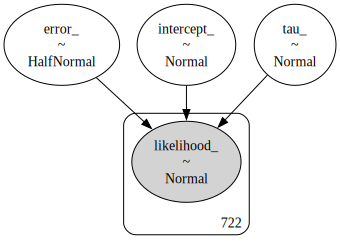

In [108]:
pm.model_to_graphviz(first_diff_model)

In [109]:
with first_diff_model:
    first_diff_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_, intercept_, error_]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


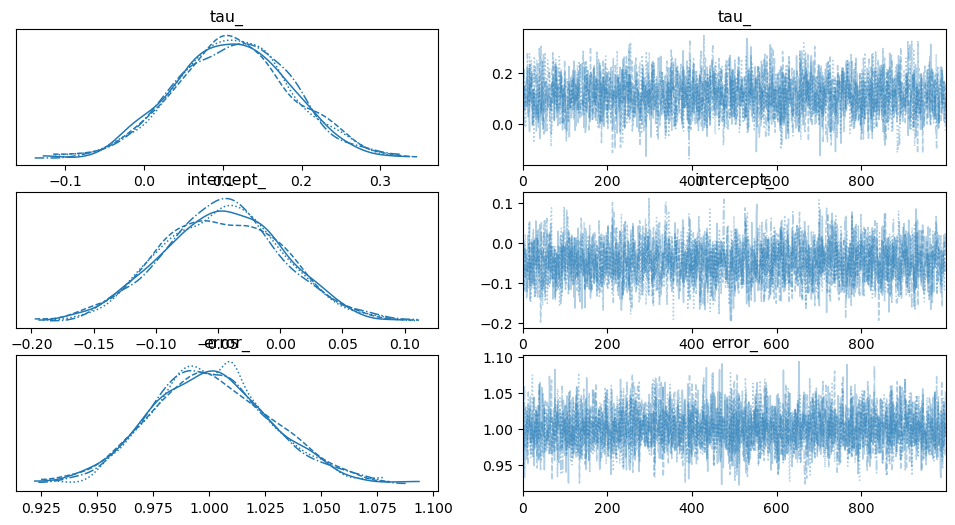

In [110]:
az.plot_trace(first_diff_trace, var_names=["tau_", "intercept_", "error_"]);

array([[<Axes: title={'center': 'tau_'}>]], dtype=object)

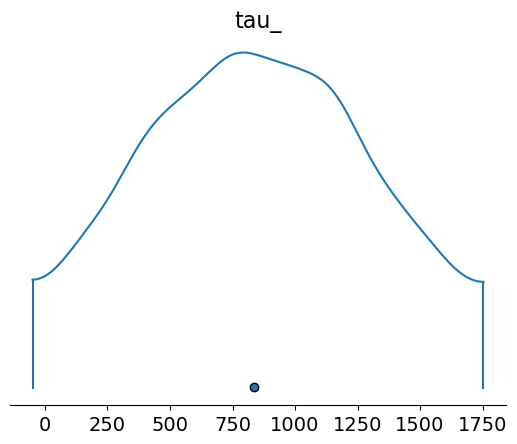

In [111]:
az.plot_density(first_diff_trace["posterior"]["tau_"] * red_std, hdi_prob=0.9)

In [112]:
az.summary(first_diff_trace["posterior"]["tau_"] * red_std, hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau_,835.804,545.266,-51.482,1755.217,11.281,7.978,2338.0,2480.0,1.0


In [113]:
# Including covariates -> they could affect the growth in wages along with the treatment status
# Goal is mainly to reduce variance
pl_covariates = pl_nsw.select(["treated", "educ", "black", "hisp", "married", "nodegree"]).with_columns(
    [
        pl.lit(age_s).alias("age_s"),
        pl.lit(1.0).alias("intercept")
    ]
)

coords = {"column": pl_covariates.columns}

arr_covariates = pl_covariates.to_numpy()

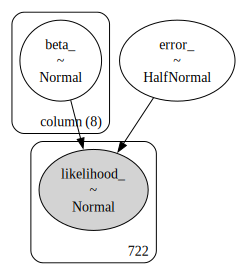

In [114]:
with pm.Model(coords=coords) as cov_diff_model:
    beta_ = pm.Normal("beta_", mu=0.0, sigma=10.0, dims="column")
    
    error_ = pm.HalfNormal("error_", sigma=10.0)
    
    mu_ = pm.math.dot(arr_covariates, beta_)
    
    likelihood_ = pm.Normal("likelihood_", mu=mu_, sigma=error_, observed=red_s)

pm.model_to_graphviz(cov_diff_model)

In [115]:
with cov_diff_model:
    cov_diff_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_, error_]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


In [116]:
cov_diff_trace["posterior"]["beta_"].sel({"column": "treated"})

<xarray.DataArray 'beta_' (chain: 4, draw: 1000)> Size: 32kB
array([[ 0.14503998,  0.0885391 ,  0.03577018, ...,  0.22338903,
         0.19777371,  0.05342582],
       [-0.08754139,  0.15206966,  0.16692752, ...,  0.18543036,
         0.16337212,  0.12210473],
       [ 0.18040457,  0.15350183,  0.10765394, ...,  0.28894948,
        -0.02700831,  0.28328252],
       [ 0.1532111 , -0.02311602,  0.15822295, ...,  0.15020951,
         0.06719074,  0.15421267]])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
    column   <U9 36B 'treated'

In [117]:
az.summary(cov_diff_trace["posterior"]["beta_"].sel({"column": "treated"}) * red_std, hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_,883.56,551.579,40.98,1867.247,8.832,7.101,3896.0,2761.0,1.0


In [118]:
with first_diff_model:
    pm.compute_log_likelihood(first_diff_trace)
    
with cov_diff_model:
    pm.compute_log_likelihood(cov_diff_trace)

Output()

Output()

In [119]:
az.compare({"cov_model": cov_diff_trace, "first_model": first_diff_trace})

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
first_model,0,-1028.238334,6.634853,0.000000,0.556625,41.257455,0.000000,False,log
cov_model,1,-1028.890896,12.215338,0.652562,0.443375,41.083699,3.441792,False,log


In [120]:
# Check PPD
with first_diff_model:
    first_diff_post = pm.sample_posterior_predictive(first_diff_trace)

Sampling: [likelihood_]


Output()

In [121]:
treated_idx = np.where(treatment_arr == 1)[0]
control_idx = np.where(treatment_arr == 0)[0]

In [122]:
first_diff_post

Inference data with groups:
	> posterior_predictive
	> observed_data

In [123]:
ppc_treated = first_diff_post

<Axes: xlabel='likelihood_'>

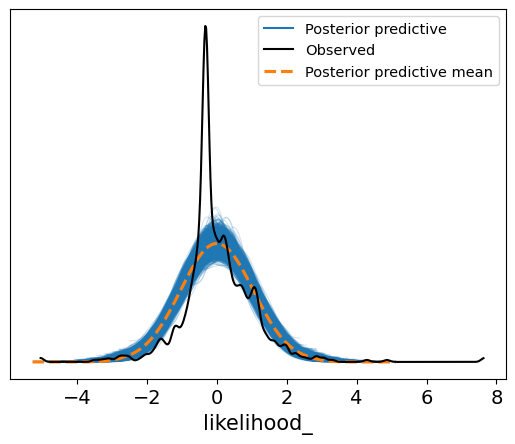

In [125]:
az.plot_ppc(ppc_treated)

In [126]:
# Naive estimate
with pm.Model() as naive_model:
    tau_ = pm.Normal("tau_", mu=0.0, sigma=10.0)
    intercept_ = pm.Normal("intercept_", mu=0.0, sigma=10.0)
    
    error_ = pm.HalfNormal("error_", sigma=10.0)
    
    mu_ = intercept_ + tau_ * treatment_arr
    
    likelihood_ = pm.Normal("likelihood_", mu=mu_, sigma=error_, observed=re78_s)

In [127]:
with naive_model:
    naive_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_, intercept_, error_]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


array([[<Axes: title={'center': 'tau_'}>]], dtype=object)

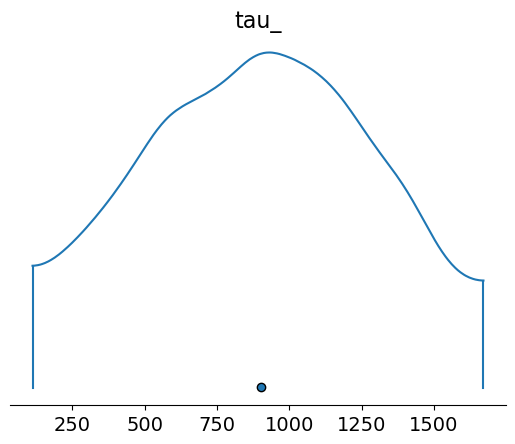

In [128]:
az.plot_density(naive_trace["posterior"]["tau_"] * re78_std, hdi_prob=0.9)

In [129]:
az.summary(naive_trace["posterior"]["tau_"] * re78_std, hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau_,901.211,472.836,111.167,1672.825,9.791,6.979,2335.0,2715.0,1.0


In [130]:
# Hierarchical diff-in-diff
pl_nsw = pl_nsw.with_columns(pl.lit(np.arange(pl_nsw.shape[0])).alias("id"))
pl_nsw.head()

pl_base = pl_nsw.unpivot(
    index=["id", "treated"],
    on=["re74", "re75", "re78"],
    variable_name="time",
    value_name="revenue",
).with_columns(
    pl.when(pl.col("treated").eq(1) & pl.col("time").eq("re78"))
    .then(1)
    .otherwise(0)
    .alias("intervened")
)

pl_base.head()

id,treated,time,revenue,intervened
i64,i64,str,f64,i32
0,1,"""re74""",0.0,0
1,1,"""re74""",8644.156,0
2,0,"""re74""",19785.32,0
3,1,"""re74""",9714.597,0
4,0,"""re74""",37211.758,0


In [131]:
ids = pl_base["id"].to_numpy()

ids_unique = pl_base["id"].unique().to_numpy()

treated_arr = pl_base["treated"].to_numpy()

one_hot_encoder = OneHotEncoder(sparse_output=False, drop="first")

one_hot_encoder.fit(pl_base["time"].to_numpy()[:, None])

one_hot_encoder.categories_

[array(['re74', 're75', 're78'], dtype=object)]

In [132]:
time_arr = one_hot_encoder.transform(pl_base["time"].to_numpy()[:, None])

revenues_s, revenues_mn, revenues_std = standardize_vec(pl_base["revenue"].to_numpy())

intervention_arr = pl_base["intervened"].to_numpy()

time_dims = ["re75", "re78"]

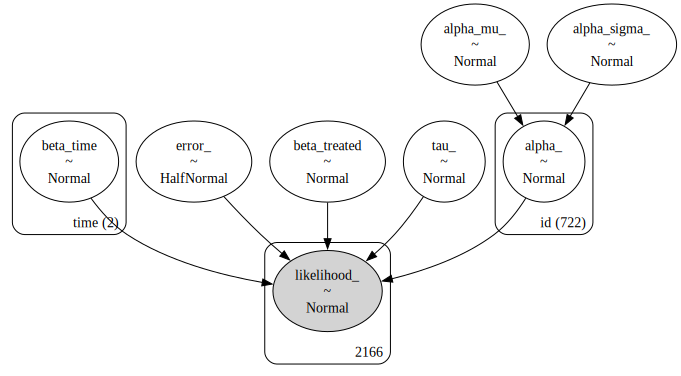

In [149]:
coords = {"time": time_dims, "id": ids_unique}

with pm.Model(coords=coords) as hierarchical_did:
    beta_time = pm.Normal("beta_time", 0.0, 10.0, dims="time")
    beta_treated = pm.Normal("beta_treated", 0.0, 10.0)
    tau_ = pm.Normal("tau_", 0.0, 10.0)  
    alpha_mu_ = pm.Normal("alpha_mu_", 0.0, 10.0)
    alpha_sigma_ = pm.Normal("alpha_sigma_", 0.0, 10.0)
    
    alpha_ = pm.Normal("alpha_", alpha_mu_, alpha_sigma_, dims="id")
    
    error_ = pm.HalfNormal("error_", 10.0)
    
    mu_ = alpha_[ids] + pm.math.dot(time_arr, beta_time) + beta_treated * treated_arr + tau_ * intervention_arr 
    
    likelihood_ = pm.Normal("likelihood_", mu=mu_, sigma=error_, observed=revenues_s) 

pm.model_to_graphviz(hierarchical_did)

In [150]:
with hierarchical_did:
    hierarchical_did_trace = pm.sample(draws=2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_time, beta_treated, tau_, alpha_mu_, alpha_sigma_, alpha_, error_]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 30 seconds.


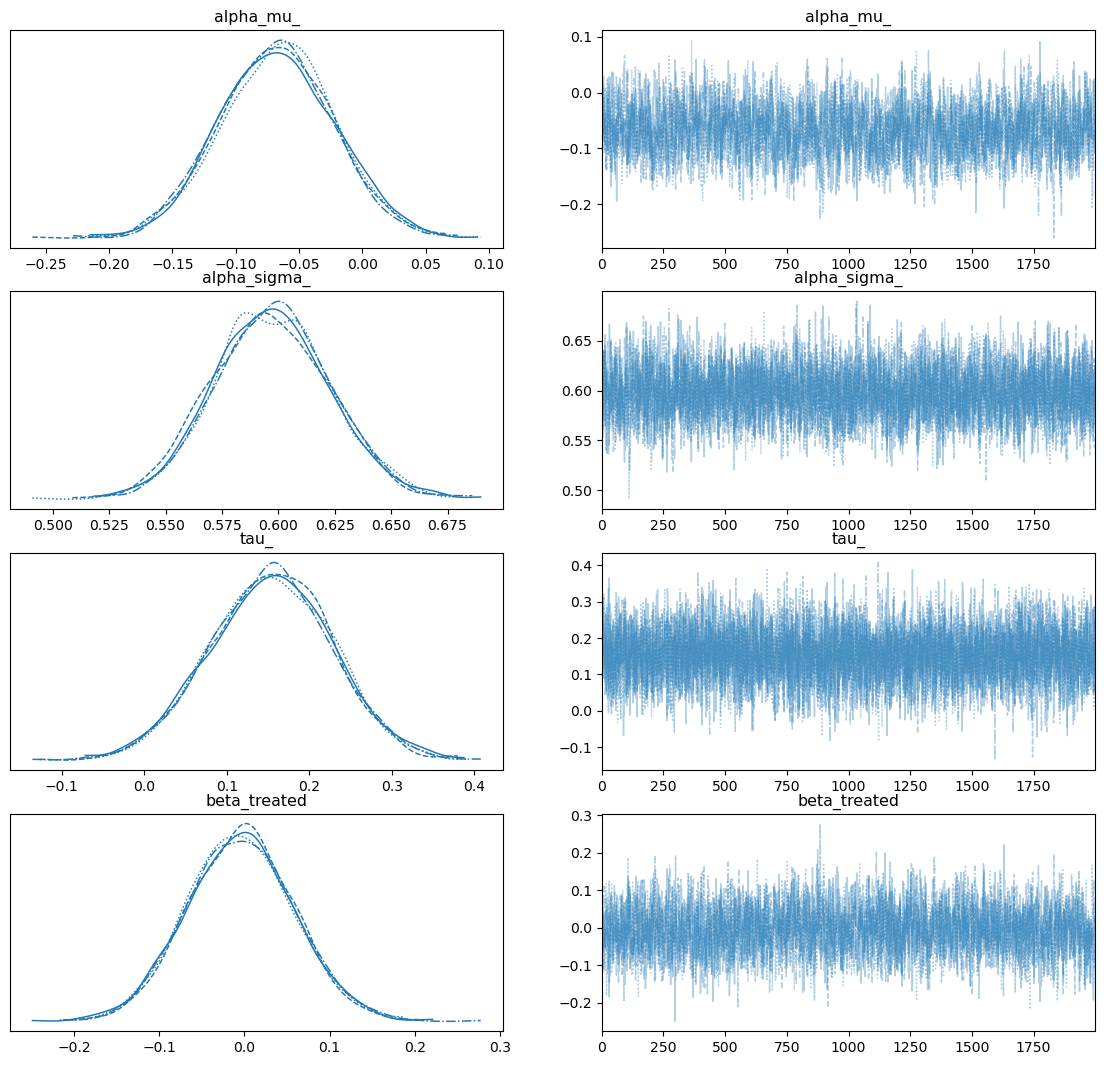

In [159]:
az.plot_trace(hierarchical_did_trace, var_names=["alpha_mu_", "alpha_sigma_", "tau_", "beta_treated"], figsize=(14, 13));

array([[<Axes: title={'center': 'tau_'}>]], dtype=object)

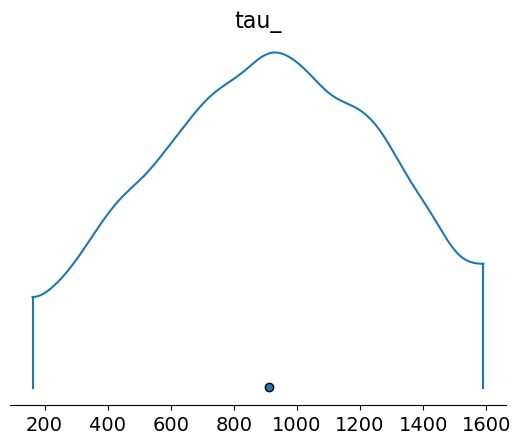

In [162]:
az.plot_density(hierarchical_did_trace["posterior"]["tau_"] * revenues_std, hdi_prob=0.9)

In [166]:
az.summary(hierarchical_did_trace["posterior"]["tau_"] * revenues_std, hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau_,911.929,435.788,160.378,1592.405,5.045,3.681,7460.0,5721.0,1.0
